In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pprint, pickle
inputs = open('/content/drive/MyDrive/ThesisData/Mods/vecsminl2.pkl', 'rb')
outputs = open('/content/drive/MyDrive/ThesisData/Mods/veclminl2.pkl', 'rb')
Minput = pickle.load(inputs)
Moutput = pickle.load(outputs)

In [ ]:
len(Minput[0])

185

In [ ]:
len(Moutput[0])

16

#TRUE PMCN

In [ ]:
import tensorflow as tf
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, input_units, output_unit, channel, reg, mask_prob, **kwargs, ):
        super(AttentionLayer, self).__init__(**kwargs)
        self.input_units = input_units
        self.output_unit = output_unit
        self.channel = channel
        self.reg = reg
        self.mask_prob = mask_prob

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_units': self.input_units,
            'output_unit': self.output_unit,
            "channel": self.channel,
            "reg": self.reg,
            "mask_prob": self.mask_prob
        })
        return config

    def build(self, input_shape):
        self.w_l_lst = []
        self.b_l_lst = []
        self.w_v_l1_lst = []
        self.w_v_l2_lst = []
        self.b_v_l_lst = []

        for i in range(self.channel):
            self.w_l_lst.append(self.add_weight("scalar_w_%s" % (i),
                                                initializer=tf.keras.initializers.glorot_normal(),
                                                regularizer=tf.keras.regularizers.l2(self.reg),
                                                shape=[self.input_units, self.output_unit]))

            self.b_l_lst.append(self.add_weight("scalar_b_%s" % (i),
                                                initializer=tf.zeros_initializer(),
                                                shape=[1, 1]))
            self.w_v_l1_lst.append(self.add_weight("vector_w1_%s" % (i),
                                                   initializer=tf.keras.initializers.glorot_normal(),
                                                   regularizer=tf.keras.regularizers.l2(self.reg),
                                                   shape=[int(self.output_unit), 1]))

            self.w_v_l2_lst.append(self.add_weight("vector_w2_%s" % (i),
                                                   initializer=tf.keras.initializers.glorot_normal(),
                                                   regularizer=tf.keras.regularizers.l2(self.reg),
                                                   shape=[self.input_units, int(self.output_unit)]))

            self.b_v_l_lst.append(self.add_weight("vector_b_%s" % (i),
                                                  initializer=tf.zeros_initializer(),
                                                  shape=[1, 1, int(self.output_unit)]))

    def call(self, inputs, pad_k):
        Mask_layer = tf.keras.layers.Dropout(self.mask_prob)
        C_l_total = []
        scalar_att_lst = []
        vector_att_lst = []
        # Zero padding
        pad_k2 = (pad_k + 99999) / 99999
        maxlen = inputs.shape[1]
        for i in range(self.channel):
            # make association matrix
            # Scalar-attention
            mat_l = tf.matmul(inputs, self.w_l_lst[i])
            mat_lj = tf.tile(tf.expand_dims(mat_l, axis=1), [1, maxlen, 1, 1])
            mat_li = tf.tile(tf.expand_dims(inputs, axis=1), [1, maxlen, 1, 1])
            mat_li = tf.transpose(mat_li, [0, 2, 1, 3])
            M_l = tf.reduce_sum((mat_li * mat_lj), axis=3) + self.b_l_lst[i]

            A_l = tf.nn.tanh(Mask_layer(M_l))

            s_lk = tf.reduce_sum(A_l, axis=2)
            s_lk = tf.expand_dims(s_lk, axis=2)
            score_lk = pad_k + s_lk  #
            a_l = tf.nn.softmax(score_lk, axis=1)
            scalar_att_lst.append(a_l)
            score_l_bar = tf.nn.tanh(tf.matmul(inputs, self.w_v_l2_lst[i]) + self.b_v_l_lst[i])
            score_l_bar = tf.matmul(score_l_bar, self.w_v_l1_lst[i]) + pad_k
            a_l_bar = tf.nn.softmax(score_l_bar, axis=1)
            new_inputs = tf.tile(tf.expand_dims(tf.reduce_sum(inputs * a_l_bar, axis=1), axis=1), [1, maxlen, 1])
            vector_att_lst.append(a_l_bar)
            C_l = a_l * inputs + new_inputs * pad_k2
            C_l = tf.expand_dims(C_l, axis=3)
            C_l_total.append(C_l)
        C_features = tf.concat(C_l_total, axis=3)
        inputs2 = tf.expand_dims(inputs, axis=3)
        C_features = tf.concat([C_features, inputs2], axis=3)
        return C_features, scalar_att_lst, vector_att_lst

In [ ]:
from keras.src.layers.rnn.lstm import activations
from tensorflow import keras
from tensorflow.keras import layers


class PMCN:
    def __init__(self, maxlen, embed_dim,activity_count, filter_size, channel, mask_prob=0.7,att_reg=0.0001 ):
        self.maxlen = maxlen
        self.activity_count = activity_count
        self.embed_dim = embed_dim
        self.filter_size = filter_size
        self.channel = channel
        self.att_reg = att_reg
        num_filter = embed_dim // filter_size
        self.num_filters = list(range(1, num_filter + 1))
        self.mask_prob = mask_prob

    def build(self, emb_trainable=True, pre_emb=True, emb_weight=None):
        inputs = layers.Input(shape=(self.maxlen,))
        pad_k = tf.expand_dims(tf.cast((inputs == 0), dtype=tf.float32) * -99999, axis=2)

        if pre_emb:
            emb_layer = layers.Embedding(self.activity_count + 1, self.embed_dim, trainable=emb_trainable,
                                         weights=[emb_weight])
        else:
            emb_layer = layers.Embedding(self.activity_count + 1, self.embed_dim, trainable=
            True)
        inputs_emb = emb_layer(inputs)
        lstm_layer = layers.LSTM(self.embed_dim, return_sequences=True)
        bi_lstm = layers.Bidirectional(lstm_layer, merge_mode="ave")(inputs_emb)

        C_features, self.scalar_att, self.vector_att = AttentionLayer(self.embed_dim, self.embed_dim, self.channel, 0.0001,
                                                            self.mask_prob)(bi_lstm, pad_k)
        inputs_emb2 = tf.expand_dims(inputs_emb, axis=3)
        C_features = tf.concat([inputs_emb2, C_features], axis=3)

        # kim-cnn process
        pools = []
        for filter_sizes in self.num_filters:
            cnn_layers = layers.Conv2D(self.filter_size, kernel_size=(filter_sizes, self.embed_dim), activation="relu")
            cnn_out = cnn_layers(C_features)
            max_pools = layers.MaxPool2D(pool_size=(self.maxlen - filter_sizes + 1, 1))(cnn_out)
            max_pools = layers.Flatten()(max_pools)
            pools.append(max_pools)
        concated = layers.concatenate(pools)

        # Higy-way process
        gap_input_emb = layers.GlobalAvgPool1D()(inputs_emb)
        trans_ = layers.Dense(self.embed_dim, activation="softmax", use_bias=True)(gap_input_emb)
        carry_ = 1 - trans_
        gap_ = layers.Multiply()([trans_, gap_input_emb])
        concated_ = layers.Multiply()([carry_, concated])
        concated_ = layers.Add()([concated_, gap_])
        outputs = layers.Dense(16, activation="softmax")(concated_)

        self.model = keras.Model(inputs=inputs, outputs=outputs)
        return self.model

    def load_weights(self, path):
        self.model.load_weights(path)

In [ ]:
from keras import backend as K
import tensorflow as tf

## Evaluate Method
def k_recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn)
    count_true_positive_false_negative = K.sum(y_target_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
    return recall

def k_precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn)
    count_true_positive_false_positive = K.sum(y_pred_yn)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())
    return precision

def k_f1score(y_target, y_pred):
    _recall = k_recall(y_target, y_pred)
    _precision = k_precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    return _f1score
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [ ]:
import pandas as pd
from gensim.models import word2vec
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score
from sklearn.model_selection import train_test_split
import pickle
from tensorflow import keras
import numpy as np
import argparse
from tensorflow.keras import backend as K
import os

init_weight = np.random.uniform(size=(16 + 1, 50), low=-1, high=1)
def main():
    tf.keras.backend.clear_session()
    PMCN = PMCN(maxlen=185,
                  embed_dim=100,
                  activity_count=10,
                  filter_size=50,
                  channel=2,
                  mask_prob=0.5,
                  att_reg=0.0001)
    model = PMCN.build(emb_trainable=False, emb_weight=init_weight)
    return model

In [ ]:
Moutput.shape

(14164, 16)

In [ ]:
tf.keras.backend.clear_session()
PMCN = PMCN(maxlen=65,
              embed_dim=50,
              activity_count=42,
              filter_size=25,
              channel=5,
              mask_prob=0.5,
              att_reg=0.0001)
model = PMCN.build(emb_trainable=True, emb_weight=init_weight)

In [ ]:
warmup_lr_rate = 0.0001

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Minput, Moutput, test_size=0.33, random_state=42)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(warmup_lr_rate), loss="binary_crossentropy",
                      metrics=["accuracy", k_precision, k_recall, k_f1score])


# Define callbacks condition
callbacks = ModelCheckpoint("model-{epoch:04d}.h5", monitor='val_loss',
                            verbose=1,save_best_only=True, save_weights_only=True) #  period=period,


# Define reduce Learning rate schedule
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.9,
                                cooldown=0,
                                patience=5,
                                min_lr=0.008*0.01,
                                verbose=1)


# Train Warm up stage
print("===========Warm up %d Epoch Stage==========="%(int(30*0.1)))
# warm up embedding weight
model.fit(X_train, y_train, epochs=int(30*0.1), callbacks=[callbacks, lr_reducer],
                  batch_size=128,verbose=1)
print("============Main %d Epoch Stage============="%(30-int(30*0.1)))
K.set_value(model.optimizer.learning_rate, 0.0051)
history = model.fit(X_train, y_train, epochs=20-int(30 * 0.1), callbacks=[callbacks, lr_reducer],
          batch_size=128,verbose=1)
print("Complete Training Model")

===========Warm up 3 Epoch Stage===========
Epoch 1/3
9832/9832 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.7840 - k_precision: 0.8070 - k_recall: 0.7149 - k_f1score: 0.7415

9832/9832 [==============================] - 298s 29ms/step - loss: 0.0476 - accuracy: 0.7840 - k_precision: 0.8070 - k_recall: 0.7149 - k_f1score: 0.7415 - lr: 1.0000e-04
Epoch 2/3
9832/9832 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.8540 - k_precision: 0.8631 - k_recall: 0.8492 - k_f1score: 0.8560

9832/9832 [==============================] - 285s 29ms/step - loss: 0.0238 - accuracy: 0.8540 - k_precision: 0.8631 - k_recall: 0.8492 - k_f1score: 0.8560 - lr: 1.0000e-04
Epoch 3/3
9831/9832 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.8591 - k_precision: 0.8659 - k_recall: 0.8558 - k_f1score: 0.8608

9832/9832 [==============================] - 284s 29ms/step - loss: 0.0210 - accuracy: 0.8591 - k_precision: 0.8659 - k_recall: 0.8558 - k_f1score: 0.8608 - lr: 1.0000e-04
============Main 27 Epoch Stage=============
Epoch 1/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.8663 - k_precision: 0.8698 - k_recall: 0.8636 - k_f1score: 0.8667

9832/9832 [==============================] - 281s 29ms/step - loss: 0.0189 - accuracy: 0.8663 - k_precision: 0.8698 - k_recall: 0.8636 - k_f1score: 0.8667 - lr: 0.0051
Epoch 2/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.8712 - k_precision: 0.8734 - k_recall: 0.8694 - k_f1score: 0.8714

9832/9832 [==============================] - 280s 28ms/step - loss: 0.0179 - accuracy: 0.8712 - k_precision: 0.8734 - k_recall: 0.8694 - k_f1score: 0.8714 - lr: 0.0051
Epoch 3/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.8722 - k_precision: 0.8742 - k_recall: 0.8705 - k_f1score: 0.8724

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0177 - accuracy: 0.8722 - k_precision: 0.8742 - k_recall: 0.8705 - k_f1score: 0.8724 - lr: 0.0051
Epoch 4/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8727 - k_precision: 0.8747 - k_recall: 0.8710 - k_f1score: 0.8729

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0176 - accuracy: 0.8727 - k_precision: 0.8747 - k_recall: 0.8710 - k_f1score: 0.8729 - lr: 0.0051
Epoch 5/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8730 - k_precision: 0.8749 - k_recall: 0.8714 - k_f1score: 0.8731

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0176 - accuracy: 0.8730 - k_precision: 0.8750 - k_recall: 0.8714 - k_f1score: 0.8732 - lr: 0.0051
Epoch 6/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8752 - k_recall: 0.8718 - k_f1score: 0.8735

9832/9832 [==============================] - 280s 28ms/step - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8752 - k_recall: 0.8718 - k_f1score: 0.8735 - lr: 0.0051
Epoch 7/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8752 - k_recall: 0.8718 - k_f1score: 0.8735

9832/9832 [==============================] - 280s 28ms/step - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8752 - k_recall: 0.8718 - k_f1score: 0.8735 - lr: 0.0051
Epoch 8/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8753 - k_recall: 0.8717 - k_f1score: 0.8735

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8753 - k_recall: 0.8717 - k_f1score: 0.8735 - lr: 0.0051
Epoch 9/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.8735 - k_precision: 0.8754 - k_recall: 0.8720 - k_f1score: 0.8737

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0175 - accuracy: 0.8735 - k_precision: 0.8754 - k_recall: 0.8720 - k_f1score: 0.8737 - lr: 0.0051
Epoch 10/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.8736 - k_precision: 0.8756 - k_recall: 0.8721 - k_f1score: 0.8738

9832/9832 [==============================] - 280s 28ms/step - loss: 0.0175 - accuracy: 0.8736 - k_precision: 0.8756 - k_recall: 0.8721 - k_f1score: 0.8738 - lr: 0.0051
Epoch 11/17
9832/9832 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.8735 - k_precision: 0.8755 - k_recall: 0.8720 - k_f1score: 0.8737

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0176 - accuracy: 0.8735 - k_precision: 0.8755 - k_recall: 0.8720 - k_f1score: 0.8737 - lr: 0.0051
Epoch 12/17
9832/9832 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.8735 - k_precision: 0.8753 - k_recall: 0.8719 - k_f1score: 0.8736

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0176 - accuracy: 0.8735 - k_precision: 0.8753 - k_recall: 0.8719 - k_f1score: 0.8736 - lr: 0.0051
Epoch 13/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8735 - k_precision: 0.8755 - k_recall: 0.8720 - k_f1score: 0.8737

9832/9832 [==============================] - 279s 28ms/step - loss: 0.0176 - accuracy: 0.8735 - k_precision: 0.8755 - k_recall: 0.8720 - k_f1score: 0.8737 - lr: 0.0051
Epoch 14/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8734 - k_precision: 0.8753 - k_recall: 0.8719 - k_f1score: 0.8736

9832/9832 [==============================] - 280s 28ms/step - loss: 0.0176 - accuracy: 0.8734 - k_precision: 0.8754 - k_recall: 0.8720 - k_f1score: 0.8736 - lr: 0.0051
Epoch 15/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8734 - k_precision: 0.8754 - k_recall: 0.8717 - k_f1score: 0.8736

9832/9832 [==============================] - 280s 29ms/step - loss: 0.0176 - accuracy: 0.8734 - k_precision: 0.8754 - k_recall: 0.8717 - k_f1score: 0.8735 - lr: 0.0051
Epoch 16/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8753 - k_recall: 0.8717 - k_f1score: 0.8735

9832/9832 [==============================] - 281s 29ms/step - loss: 0.0176 - accuracy: 0.8733 - k_precision: 0.8753 - k_recall: 0.8717 - k_f1score: 0.8735 - lr: 0.0051
Epoch 17/17
9831/9832 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8734 - k_precision: 0.8754 - k_recall: 0.8717 - k_f1score: 0.8736

9832/9832 [==============================] - 281s 29ms/step - loss: 0.0176 - accuracy: 0.8734 - k_precision: 0.8754 - k_recall: 0.8717 - k_f1score: 0.8736 - lr: 0.0051
Complete Training Model


In [ ]:
for i in history.history['accuracy']:
  print(i,",")

0.8663381338119507 ,
0.8711641430854797 ,
0.872221827507019 ,
0.8726629018783569 ,
0.8729767799377441 ,
0.8732692003250122 ,
0.8732843399047852 ,
0.873260498046875 ,
0.8734694719314575 ,
0.8736117482185364 ,
0.8735179305076599 ,
0.8734583258628845 ,
0.8734710812568665 ,
0.8734201788902283 ,
0.8733661770820618 ,
0.8733025789260864 ,
0.8733764886856079 ,


In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

19369/19369 [==============================] - 132s 7ms/step - loss: 0.0177 - accuracy: 0.8723 - k_precision: 0.8745 - k_recall: 0.8704 - k_f1score: 0.8724


[0.01768326945602894,
 0.8722777962684631,
 0.8745300769805908,
 0.8703787326812744,
 0.8724091649055481]

# Model

In [ ]:
import tensorflow as tf
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, input_units, output_unit, channel, reg, mask_prob, **kwargs, ):
        super(AttentionLayer, self).__init__(**kwargs)
        self.input_units = input_units
        self.output_unit = output_unit
        self.channel = channel
        self.reg = reg
        self.mask_prob = mask_prob

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_units': self.input_units,
            'output_unit': self.output_unit,
            "channel": self.channel,
            "reg": self.reg,
            "mask_prob": self.mask_prob
        })
        return config

    def build(self, input_shape):
        self.w_l_lst = []
        self.b_l_lst = []
        self.w_v_l1_lst = []
        self.w_v_l2_lst = []
        self.b_v_l_lst = []

        for i in range(self.channel):
            self.w_l_lst.append(self.add_weight("scalar_w_%s" % (i),
                                                initializer=tf.keras.initializers.glorot_normal(),
                                                regularizer=tf.keras.regularizers.l2(self.reg),
                                                shape=[self.input_units, self.output_unit]))

            self.b_l_lst.append(self.add_weight("scalar_b_%s" % (i),
                                                initializer=tf.zeros_initializer(),
                                                shape=[1, 1]))
            self.w_v_l1_lst.append(self.add_weight("vector_w1_%s" % (i),
                                                   initializer=tf.keras.initializers.glorot_normal(),
                                                   regularizer=tf.keras.regularizers.l2(self.reg),
                                                   shape=[int(self.output_unit), 1]))

            self.w_v_l2_lst.append(self.add_weight("vector_w2_%s" % (i),
                                                   initializer=tf.keras.initializers.glorot_normal(),
                                                   regularizer=tf.keras.regularizers.l2(self.reg),
                                                   shape=[self.input_units, int(self.output_unit)]))

            self.b_v_l_lst.append(self.add_weight("vector_b_%s" % (i),
                                                  initializer=tf.zeros_initializer(),
                                                  shape=[1, 1, int(self.output_unit)]))

    def call(self, inputs, pad_k):
        Mask_layer = tf.keras.layers.Dropout(self.mask_prob)
        C_l_total = []
        scalar_att_lst = []
        vector_att_lst = []
        # Zero padding
        pad_k2 = (pad_k + 99999) / 99999
        maxlen = inputs.shape[1]
        for i in range(self.channel):
            # make association matrix
            # Scalar-attention
            mat_l = tf.matmul(inputs, self.w_l_lst[i])
            mat_lj = tf.tile(tf.expand_dims(mat_l, axis=1), [1, maxlen, 1, 1])
            mat_li = tf.tile(tf.expand_dims(inputs, axis=1), [1, maxlen, 1, 1])
            mat_li = tf.transpose(mat_li, [0, 2, 1, 3])
            # M_l = tf.nn.tanh(tf.reduce_sum((mat_li*mat_lj)/np.sqrt(self.output_unit),axis=3)+self.b_l_lst[i])
            M_l = tf.reduce_sum((mat_li * mat_lj), axis=3) + self.b_l_lst[i]  # /np.sqrt(self.output_unit)

            A_l = tf.nn.tanh(Mask_layer(M_l))

            s_lk = tf.reduce_sum(A_l, axis=2)
            s_lk = tf.expand_dims(s_lk, axis=2)
            score_lk = pad_k + s_lk  #
            a_l = tf.nn.softmax(score_lk, axis=1)
            scalar_att_lst.append(a_l)

            # vectorical attention
            score_l_bar = tf.nn.tanh(tf.matmul(inputs, self.w_v_l2_lst[i]) + self.b_v_l_lst[i])
            score_l_bar = tf.matmul(score_l_bar, self.w_v_l1_lst[i]) + pad_k
            a_l_bar = tf.nn.softmax(score_l_bar, axis=1)
            new_inputs = tf.tile(tf.expand_dims(tf.reduce_sum(inputs * a_l_bar, axis=1), axis=1), [1, maxlen, 1])
            vector_att_lst.append(a_l_bar)
            C_l = a_l * inputs + new_inputs * pad_k2

            C_l = tf.expand_dims(C_l, axis=3)
            C_l_total.append(C_l)
        C_features = tf.concat(C_l_total, axis=3)
        inputs2 = tf.expand_dims(inputs, axis=3)
        C_features = tf.concat([C_features, inputs2], axis=3)
        return C_features, scalar_att_lst, vector_att_lst  # feature,scal attention, vector attention

In [ ]:
from pickle import load
from numpy import array
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import Conv2D
from keras.layers import MaxPooling1D
from keras.layers import concatenate
from keras.layers import MaxPool2D
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GlobalAvgPool1D
from keras.layers import Multiply
from keras.layers import Add
from keras.layers import BatchNormalization
tf.config.run_functions_eagerly(True)

model 1

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 tf.__operators__.eq_1 (TFOpLam  (None, 7)           0           ['input_2[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.cast_1 (TFOpLambda)         (None, 7)            0           ['tf.__operators__.eq_1[0][0]']  
                                                                                                  
 embedding_1 (Embedding)        (None, 7, 7)         63          ['input_2[0][0]']          

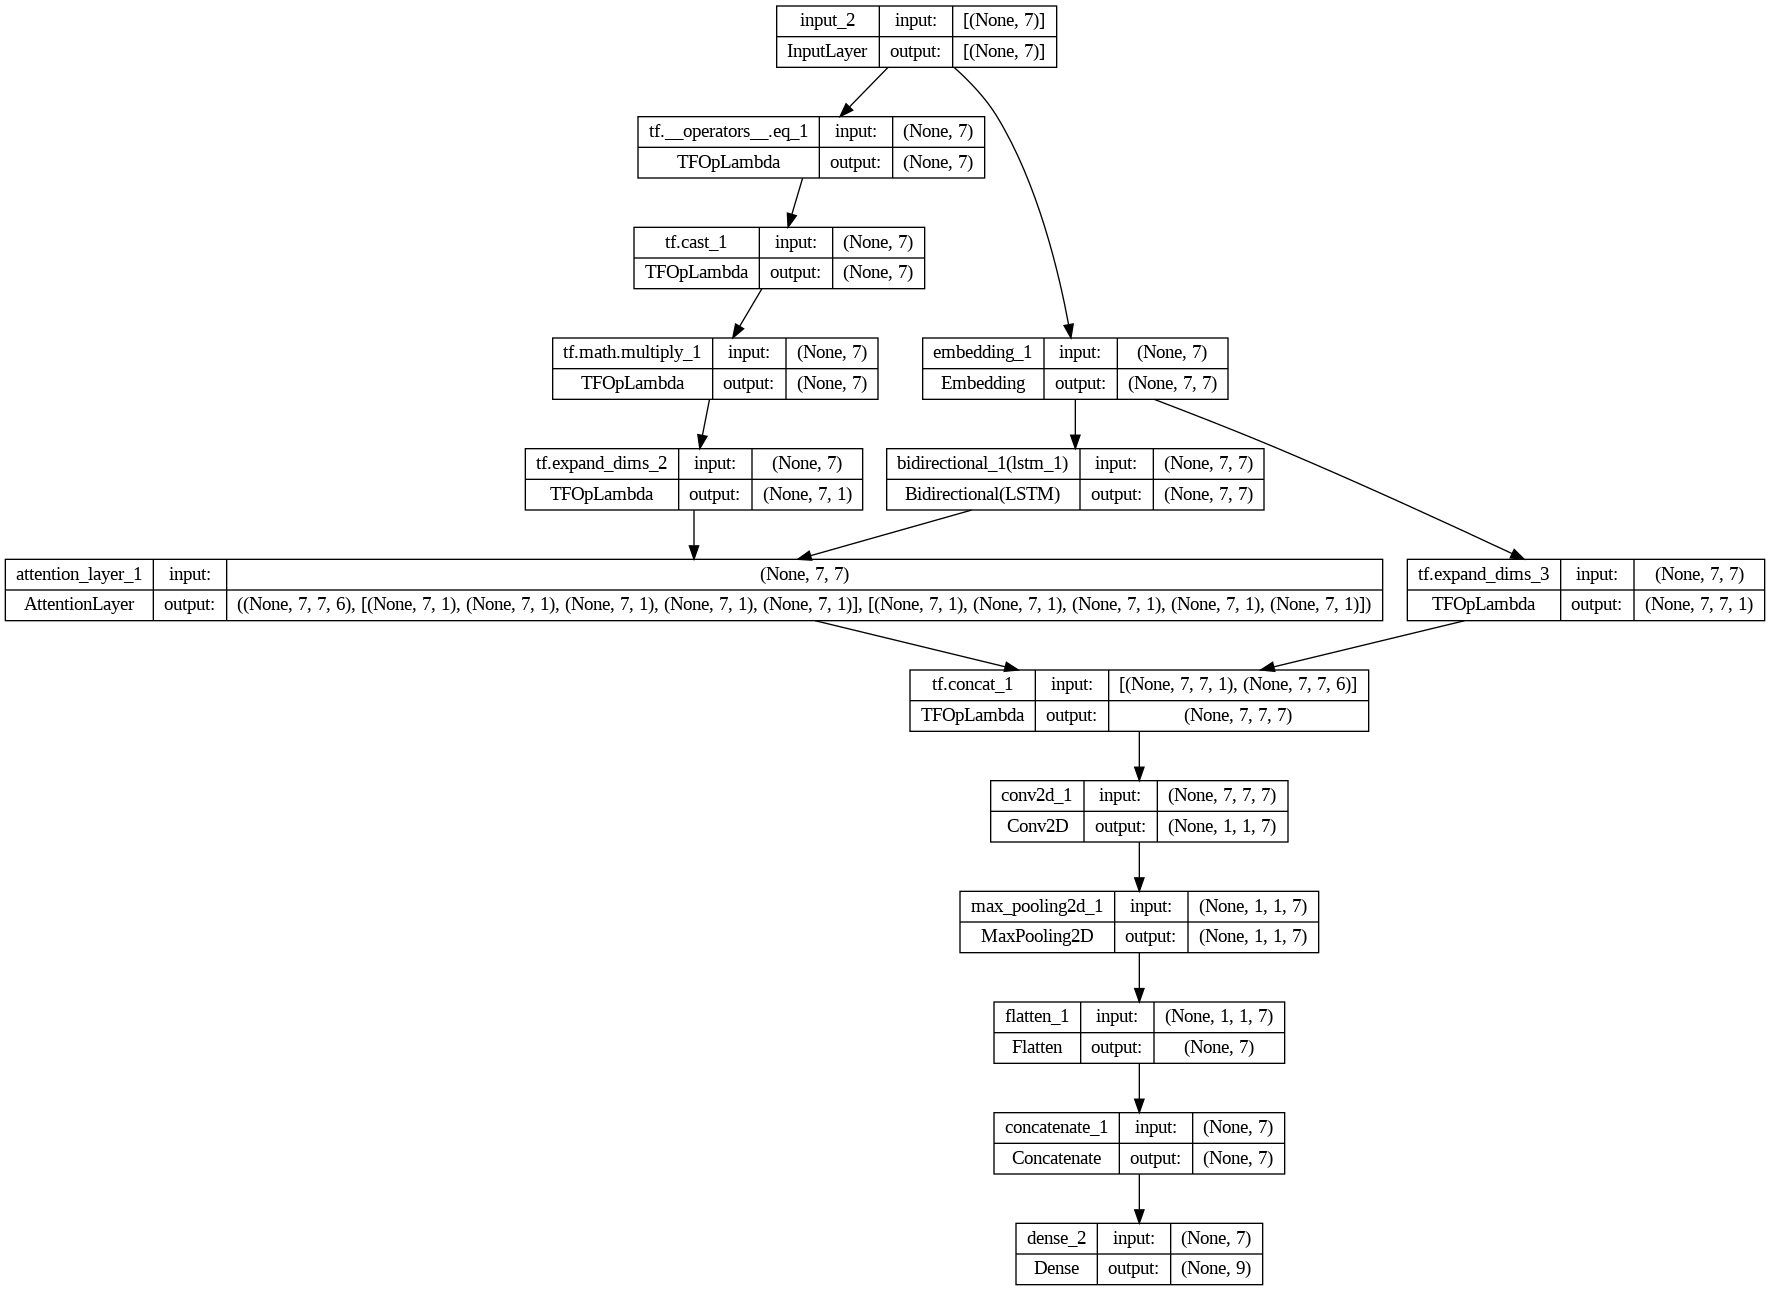

In [ ]:
inputs1 = Input(shape=(7,))
pad_k = tf.expand_dims(tf.cast((inputs1 == 0), dtype=tf.float32) * -99999, axis=2)
emb_layer = Embedding(9, 7, trainable=True)
inputs_emb = emb_layer(inputs1)
lstm_layer = LSTM(7, return_sequences=True)
bi_lstm = Bidirectional(lstm_layer, merge_mode="ave")(inputs_emb)
C_features, scalar_att, vector_att = AttentionLayer(7, 7, 5, 0.0001,0.7)(bi_lstm, pad_k)
inputs_emb2 = tf.expand_dims(inputs_emb, axis=3)
C_features = tf.concat([inputs_emb2, C_features], axis=3)
num_filters = list(range(1,2))
pools = []
for filter_sizes in num_filters:
    cnn_layers = Conv2D(7, kernel_size=(7,7), activation="relu")
    cnn_out = cnn_layers(C_features)
    max_pools = MaxPool2D(pool_size=(1 - filter_sizes + 1, 1))(cnn_out)
    max_pools = Flatten()(max_pools)
    pools.append(max_pools)
concated = concatenate(pools)

outputs = Dense(9, kernel_initializer='glorot_uniform',activation="softmax")(concated)
model = Model(inputs= inputs1, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [ ]:
model.fit(Minput[0],Moutput , epochs=200, batch_size=128)

Epoch 1/200
99/99 [==============================] - 25s 256ms/step - loss: 0.5496 - accuracy: 0.0418
Epoch 2/200
99/99 [==============================] - 24s 246ms/step - loss: 0.3526 - accuracy: 0.1194
Epoch 3/200
99/99 [==============================] - 25s 249ms/step - loss: 0.2994 - accuracy: 0.3150
Epoch 4/200
99/99 [==============================] - 24s 247ms/step - loss: 0.2655 - accuracy: 0.3230
Epoch 5/200
99/99 [==============================] - 25s 250ms/step - loss: 0.2399 - accuracy: 0.3945
Epoch 6/200
99/99 [==============================] - 25s 248ms/step - loss: 0.2180 - accuracy: 0.4046
Epoch 7/200
99/99 [==============================] - 25s 250ms/step - loss: 0.2033 - accuracy: 0.4076
Epoch 8/200
99/99 [==============================] - 25s 248ms/step - loss: 0.1942 - accuracy: 0.4386
Epoch 9/200
99/99 [==============================] - 25s 251ms/step - loss: 0.1873 - accuracy: 0.5181
Epoch 10/200
99/99 [==============================] - 25s 252ms/step - loss: 0.181

KeyboardInterrupt: ignored

Model 2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 tf.__operators__.eq (TFOpLambd  (None, 7)           0           ['input_1[0][0]']                
 a)                                                                                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 7)            0           ['tf.__operators__.eq[0][0]']    
                                                                                                  
 embedding (Embedding)          (None, 7, 7)         63          ['input_1[0][0]']            

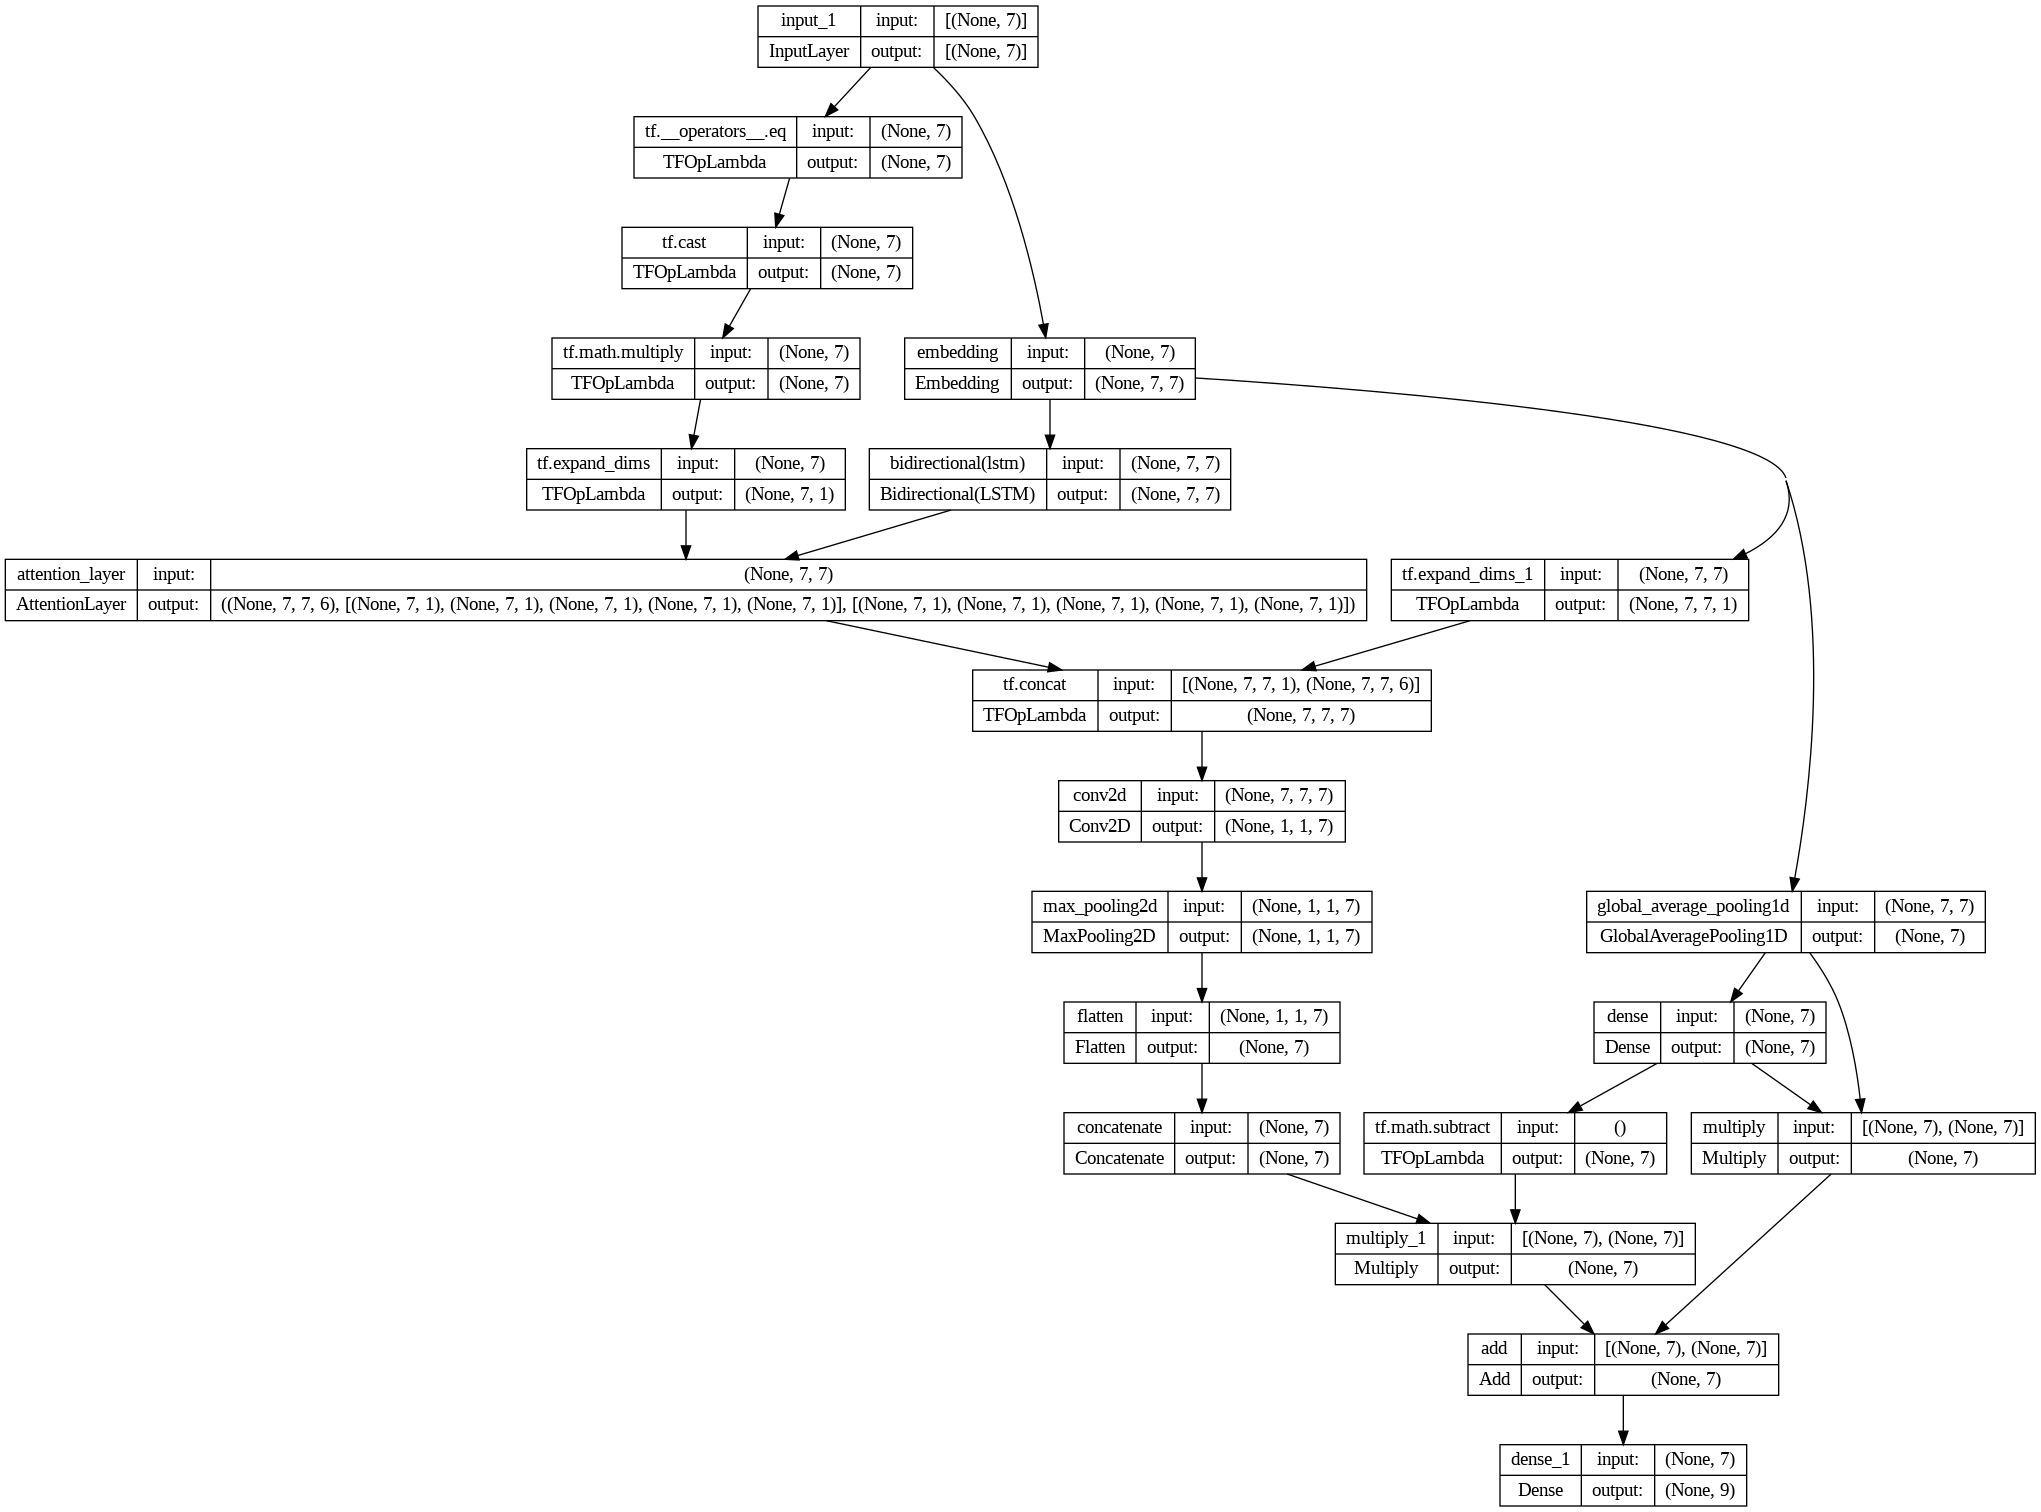

In [ ]:
inputs1 = Input(shape=(7,))
pad_k = tf.expand_dims(tf.cast((inputs1 == 0), dtype=tf.float32) * -99999, axis=2)
emb_layer = Embedding(9, 7, trainable=True)
inputs_emb = emb_layer(inputs1)
lstm_layer = LSTM(7, return_sequences=True)
bi_lstm = Bidirectional(lstm_layer, merge_mode="ave")(inputs_emb)
C_features, scalar_att, vector_att = AttentionLayer(7, 7, 5, 0.0001,0.8)(bi_lstm, pad_k)
inputs_emb2 = tf.expand_dims(inputs_emb, axis=3)
C_features = tf.concat([inputs_emb2, C_features], axis=3)
num_filters = list(range(1,2))
pools = []
for filter_sizes in num_filters:
    cnn_layers = Conv2D(7, kernel_size=(7,7), activation="relu")
    cnn_out = cnn_layers(C_features)
    max_pools = MaxPool2D(pool_size=(1 - filter_sizes + 1, 1))(cnn_out)
    max_pools = Flatten()(max_pools)
    pools.append(max_pools)
concated = concatenate(pools)
gap_input_emb = GlobalAvgPool1D()(inputs_emb)  # 임베딩 사이즈로 global average pooling
trans_ = Dense(7, activation="sigmoid", use_bias=True)(gap_input_emb)
carry_ = 1 - trans_
gap_ = Multiply()([trans_, gap_input_emb])
concated_ = Multiply()([carry_, concated])
concated_ = Add()([concated_, gap_])

outputs = Dense(9, kernel_initializer='glorot_uniform',activation="softmax")(concated_)
model = Model(inputs= inputs1, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [ ]:
model.fit(Minput[0],Moutput , epochs=200, batch_size=128)

Model 3

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_r (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 tf.__operators__.eq_6 (TFOpLam  (None, 7)           0           ['input_r[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.__operators__.eq_5 (TFOpLam  (None, 7)           0           ['input_5[0][0]']          

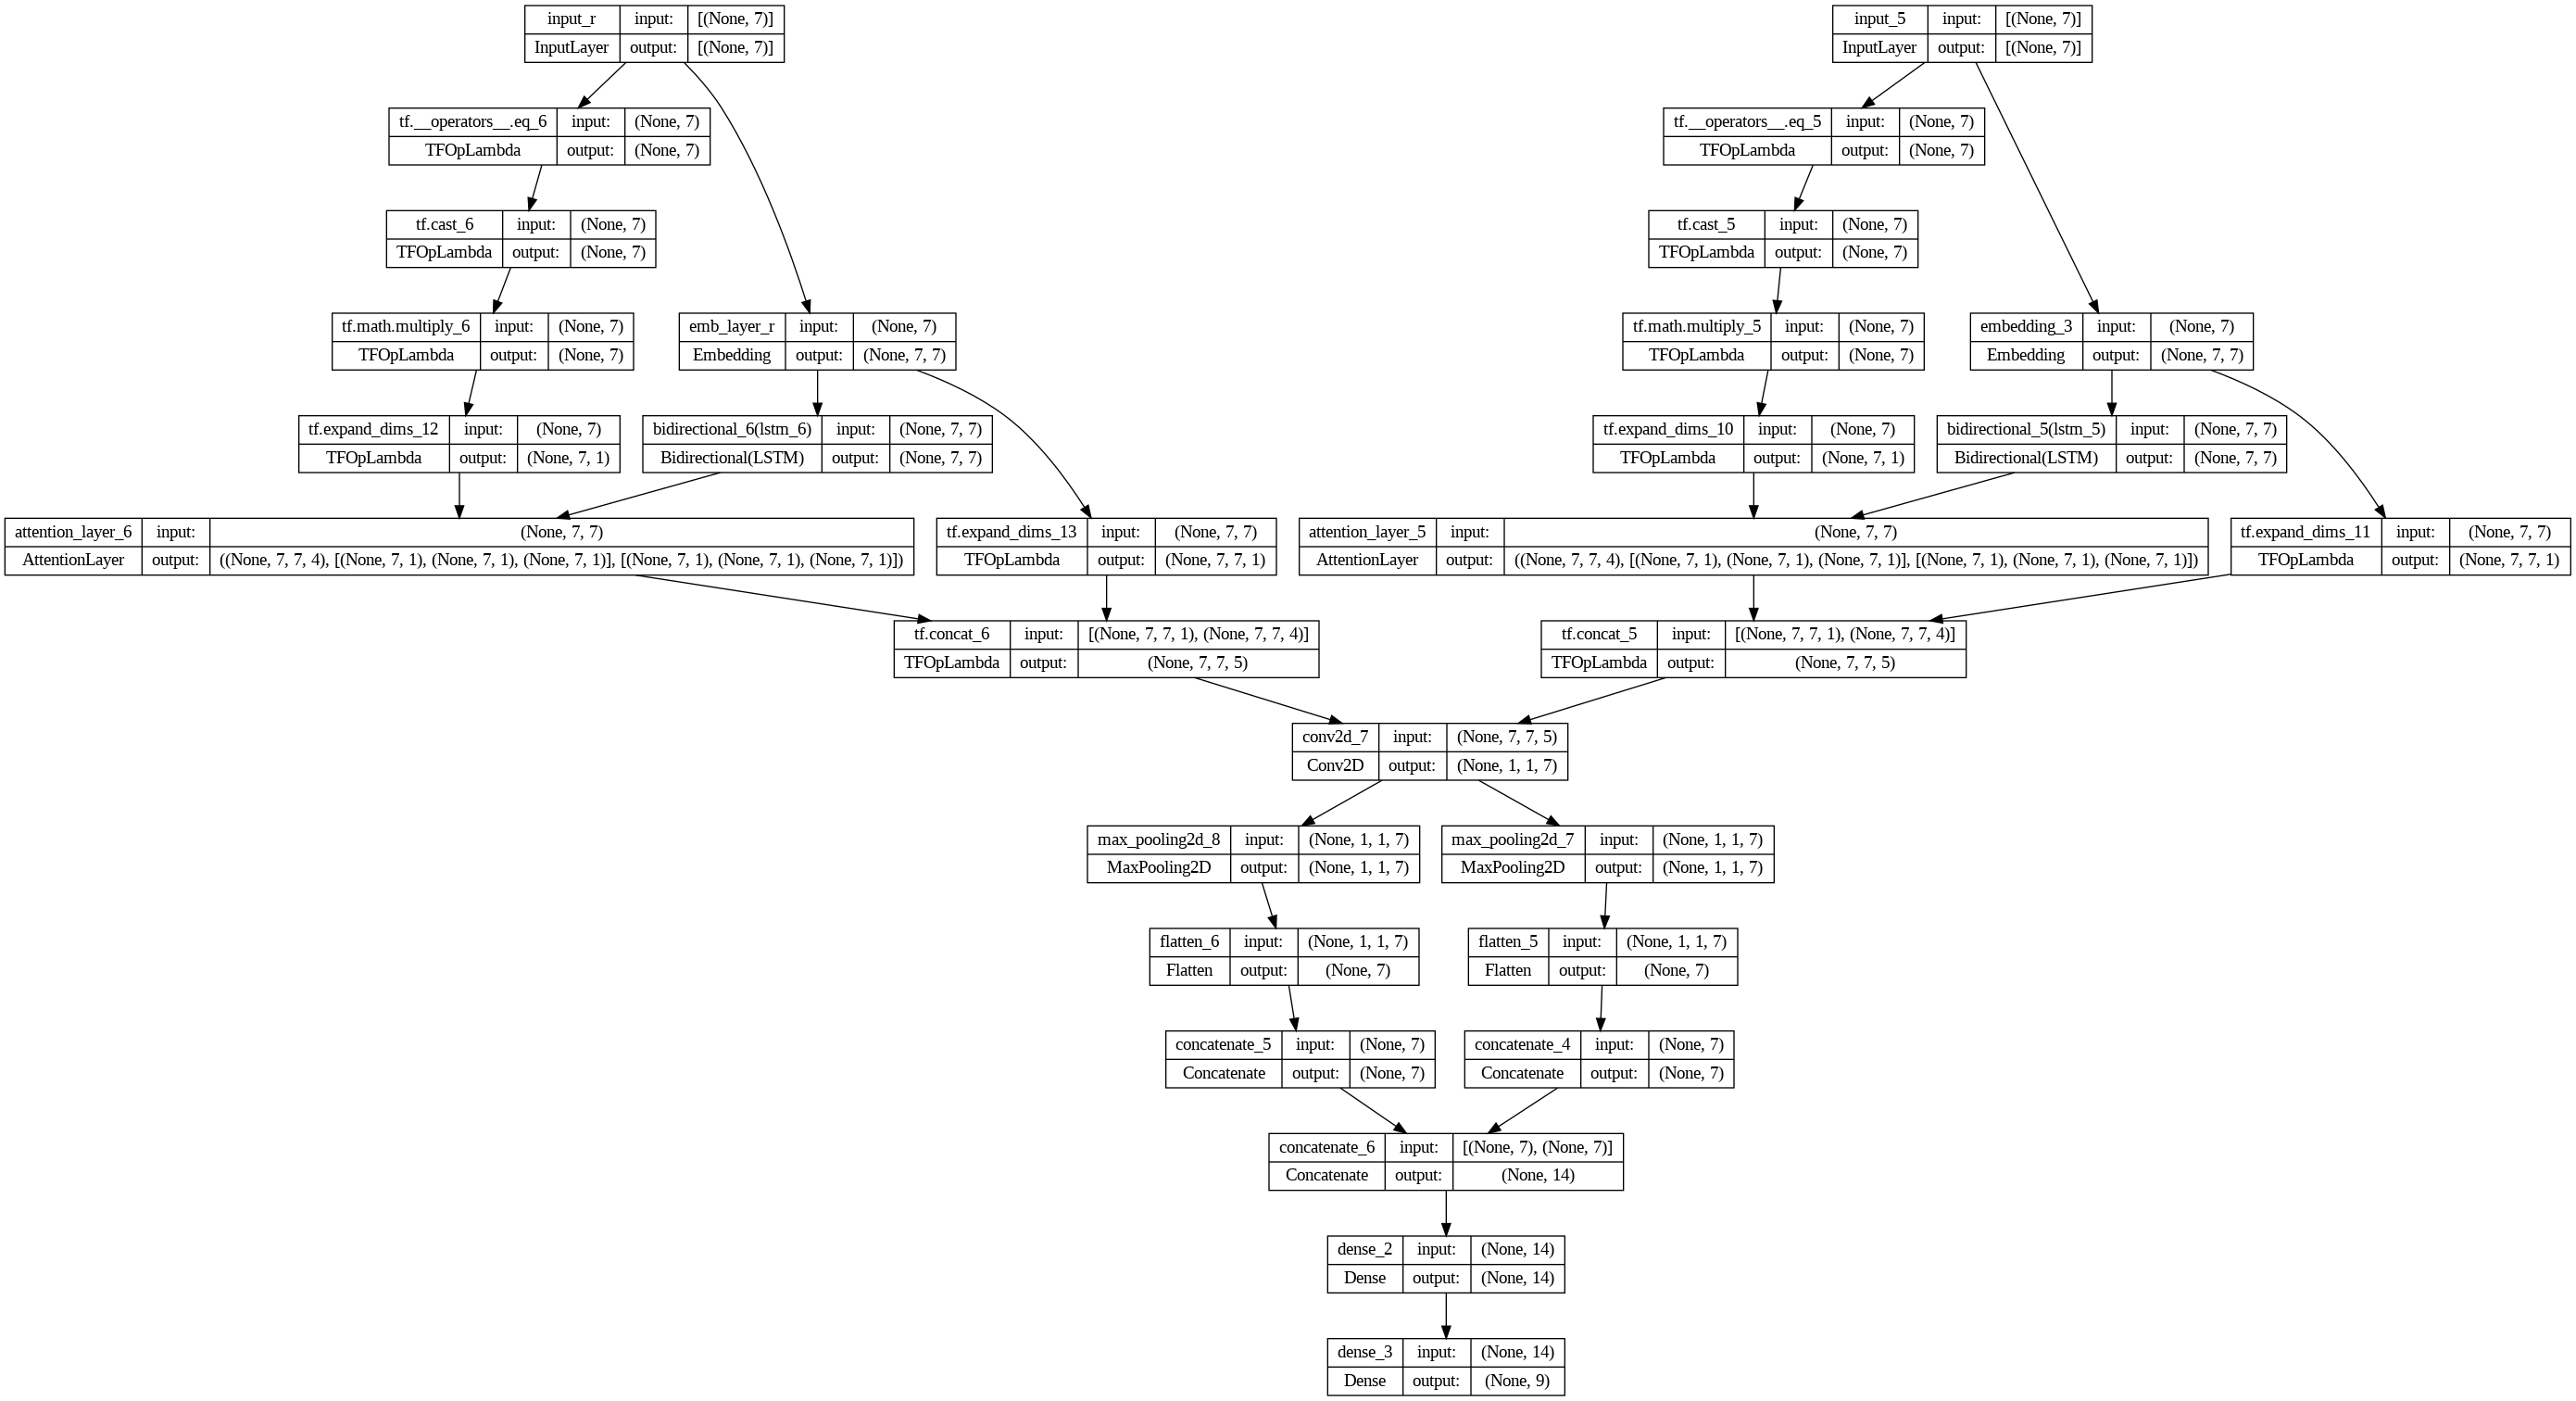

In [ ]:
inputs1 = Input(shape=(7,))
pad_k = tf.expand_dims(tf.cast((inputs1 == 0), dtype=tf.float32) * -99999, axis=2,name = "pad_k")
emb_layer = Embedding(9, 7, trainable=True)
inputs_emb = emb_layer(inputs1)
lstm_layer = LSTM(7, return_sequences=True)
bi_lstm = Bidirectional(lstm_layer, merge_mode="ave")(inputs_emb)
C_features, scalar_att, vector_att = AttentionLayer(7, 7, 3, 0.0001,0.7)(bi_lstm, pad_k)
inputs_emb2 = tf.expand_dims(inputs_emb, axis=3)
C_features = tf.concat([inputs_emb2, C_features], axis=3)
num_filters = list(range(1,2))
pools = []
for filter_sizes in num_filters:
    cnn_layers = Conv2D(7, kernel_size=(7,7), activation="relu")
    cnn_out = cnn_layers(C_features)
    max_pools = MaxPool2D(pool_size=(1 - filter_sizes + 1, 1))(cnn_out)
    max_pools = Flatten()(max_pools)
    pools.append(max_pools)
concated = concatenate(pools)


inputs_r = Input(shape=(7,), name="input_r")
pad_k_r = tf.expand_dims(tf.cast((inputs_r == 0), dtype=tf.float32) * -99999, axis=2,name="pad_r")
emb_layer_r = Embedding(9, 7, trainable=True, name="emb_layer_r")
inputs_emb_r = emb_layer_r(inputs_r)
lstm_layer_r = LSTM(7, return_sequences=True)
bi_lstm_r = Bidirectional(lstm_layer_r, merge_mode="ave")(inputs_emb_r)
C_features_r, scalar_att_r, vector_att_r = AttentionLayer(7, 7, 3, 0.0001,0.8)(bi_lstm_r, pad_k_r)
inputs_emb2_r = tf.expand_dims(inputs_emb_r, axis=3)
C_features_r = tf.concat([inputs_emb2_r, C_features_r], axis=3)

num_filters_r = list(range(1,2))
pools_r = []
for filter_sizes_r in num_filters_r:
    cnn_layers_r = Conv2D(7, kernel_size=(7,7), activation="relu")
    cnn_out_r = cnn_layers(C_features_r)
    max_pools_r = MaxPool2D(pool_size=(1 - filter_sizes_r + 1, 1))(cnn_out_r)
    max_pools_r = Flatten()(max_pools_r)
    pools_r.append(max_pools_r)
concated_r = concatenate(pools_r)


merged = concatenate([concated_r, concated])

merged_2 = Dense(14,activation="relu")(merged)

outputs = Dense(9, kernel_initializer='glorot_uniform',activation="softmax")(merged_2)
model = Model(inputs= [inputs1,inputs_r], outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [ ]:
Minput[1]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [ ]:
from tensorflow.keras import  callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

#print('This is the output file path ', output_file_path)
    # Saving
#model_checkpoint = callbacks.ModelCheckpoint(output_file_path,
#                                    monitor='val_loss',
#                                    verbose=1,
#                                    save_best_only=True,
#                                    save_weights_only=False,
#                                    mode='auto')

lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=10,
                                verbose=0,
                                mode='auto',
                                min_delta=0.0001,
                                cooldown=0,
                                min_lr=0)
model.fit([Minput[0],Minput[1]],Moutput,validation_split=0.15,verbose=1,callbacks=[early_stopping, lr_reducer] , epochs=200, batch_size=128)

Epoch 1/200
85/85 [==============================] - 31s 365ms/step - loss: 0.1105 - accuracy: 0.7474 - val_loss: 0.1023 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 2/200
33/85 [==========>...................] - ETA: 18s - loss: 0.1119 - accuracy: 0.7356

KeyboardInterrupt: ignored

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_r (InputLayer)           [(None, 73)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 73)]         0           []                               
                                                                                                  
 tf.__operators__.eq_8 (TFOpLam  (None, 73)          0           ['input_r[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.__operators__.eq_7 (TFOpLam  (None, 73)          0           ['input_6[0][0]']          

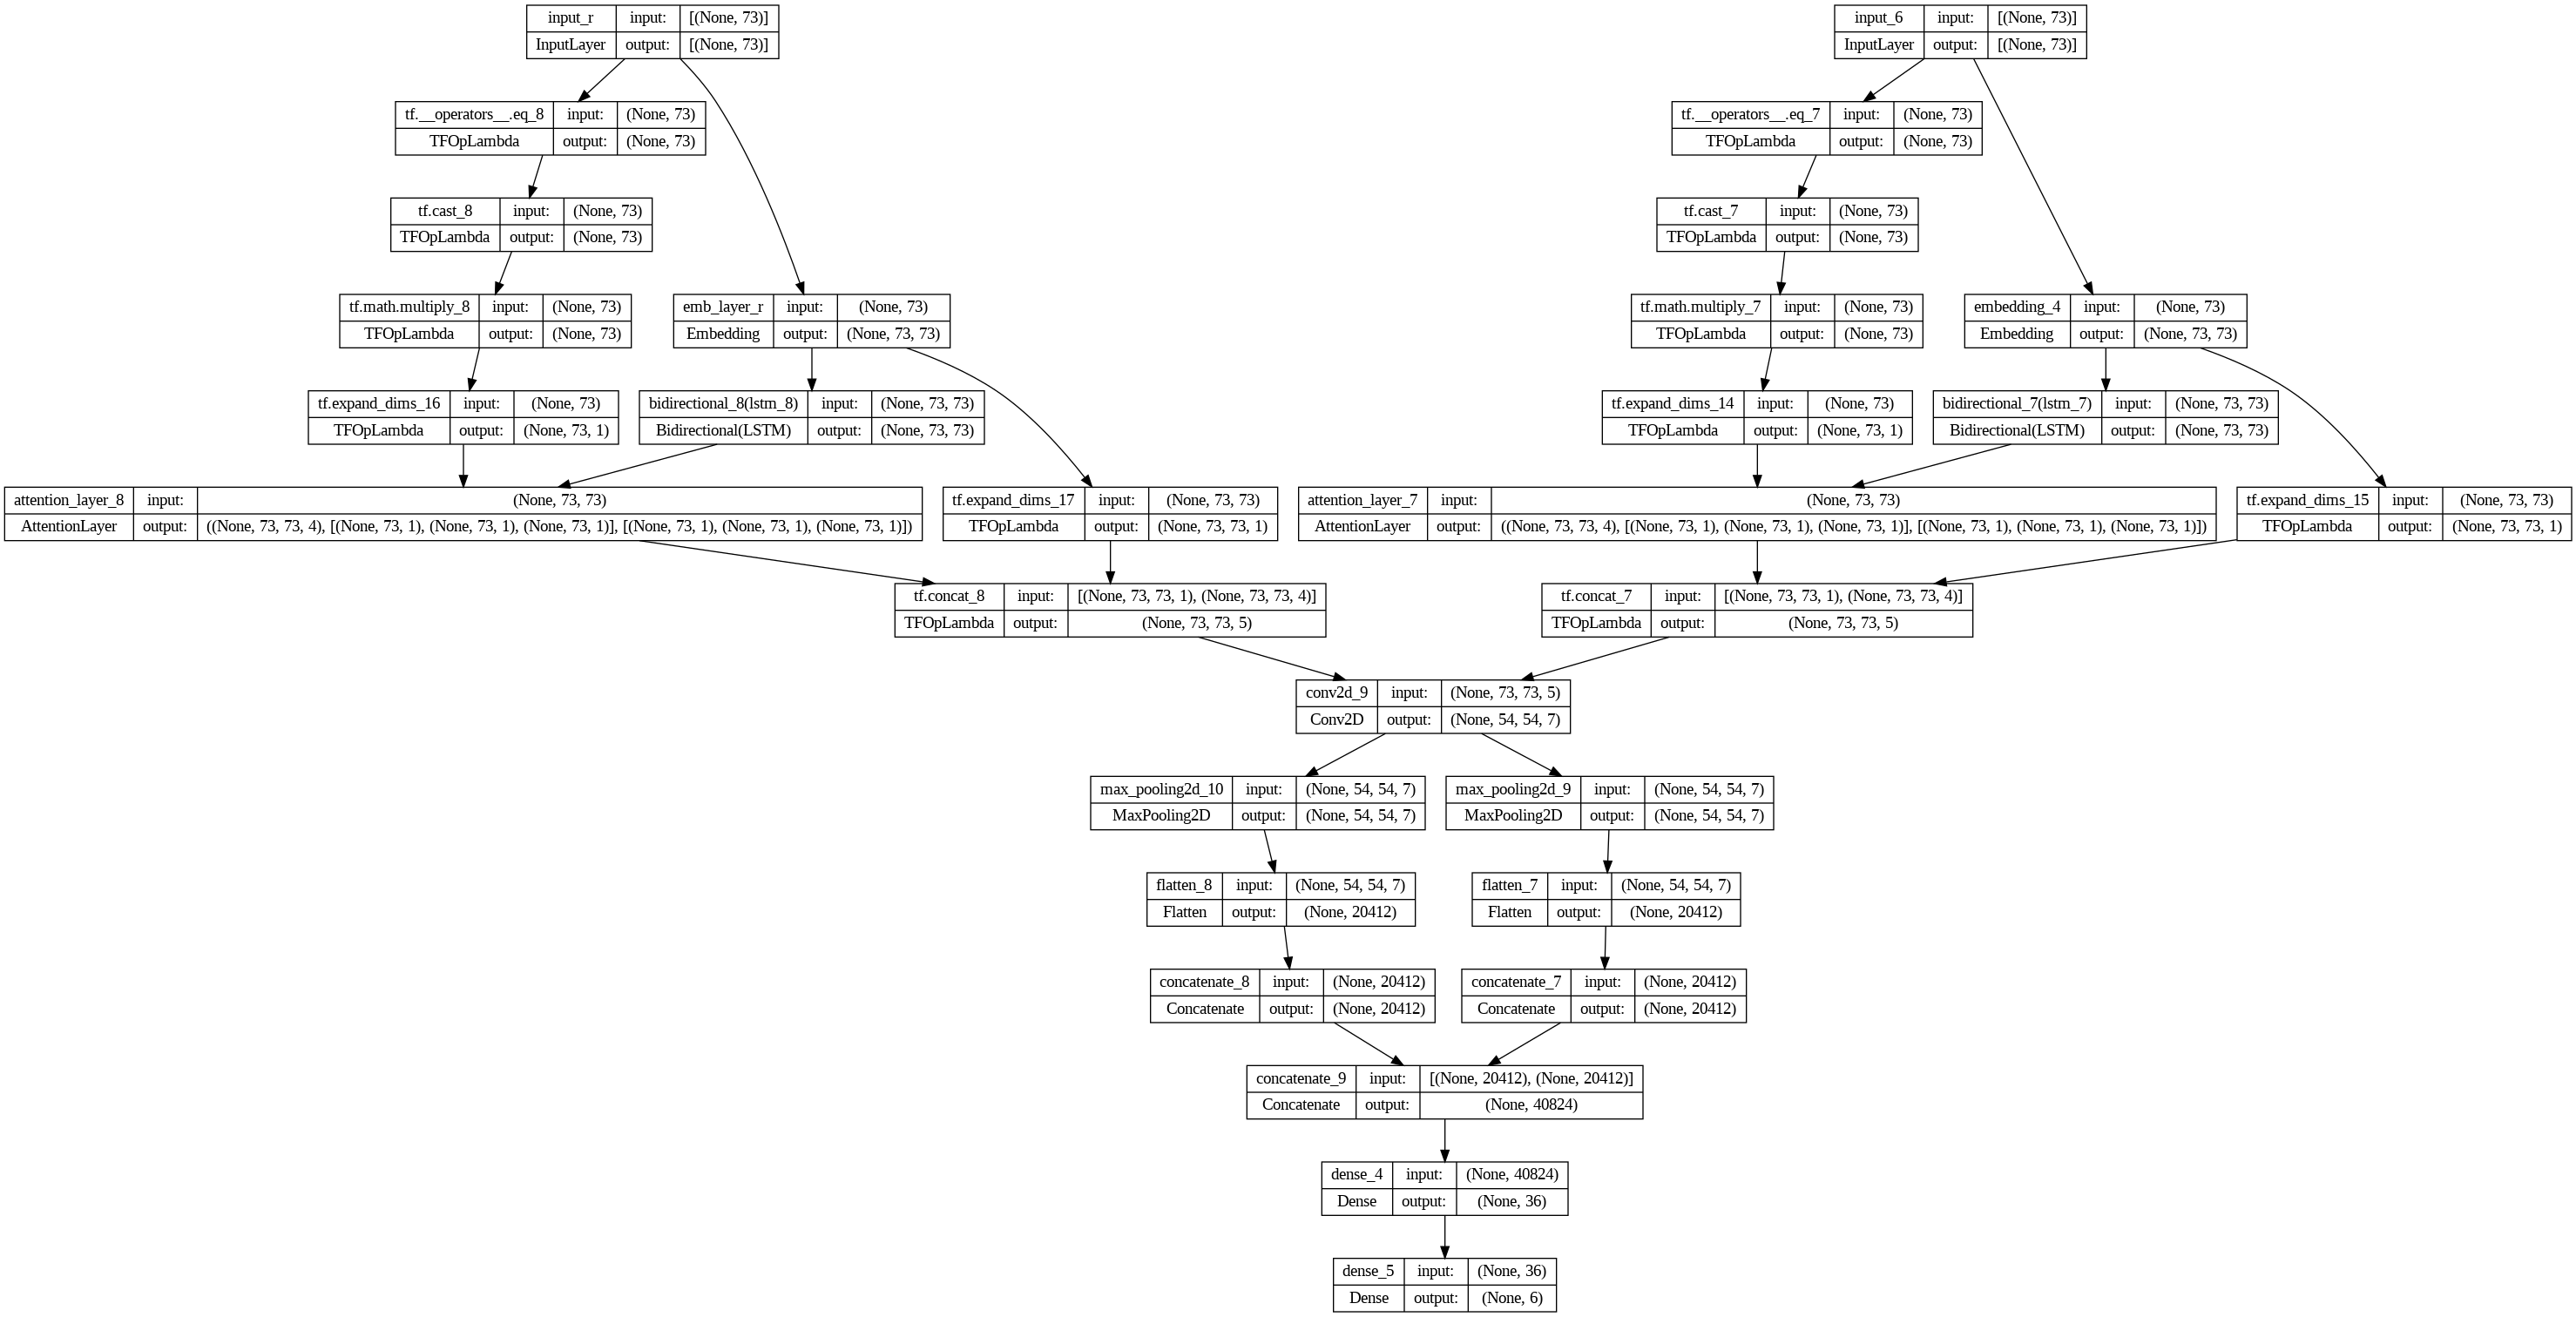

In [ ]:
inputs1 = Input(shape=(73,))
pad_k = tf.expand_dims(tf.cast((inputs1 == 0), dtype=tf.float32) * -99999, axis=2,name = "pad_k")
emb_layer = Embedding(50, 73, trainable=True)
inputs_emb = emb_layer(inputs1)
lstm_layer = LSTM(73, return_sequences=True)
bi_lstm = Bidirectional(lstm_layer, merge_mode="ave")(inputs_emb)
C_features, scalar_att, vector_att = AttentionLayer(73, 73, 3, 0.0001,0.7)(bi_lstm, pad_k)
inputs_emb2 = tf.expand_dims(inputs_emb, axis=3)
C_features = tf.concat([inputs_emb2, C_features], axis=3)
num_filters = list(range(1,2))
pools = []
for filter_sizes in num_filters:
    cnn_layers = Conv2D(7, kernel_size=(20,20), activation="relu")
    cnn_out = cnn_layers(C_features)
    max_pools = MaxPool2D(pool_size=(1 - filter_sizes + 1, 1))(cnn_out)
    max_pools = Flatten()(max_pools)
    pools.append(max_pools)
concated = concatenate(pools)


inputs_r = Input(shape=(73,), name="input_r")
pad_k_r = tf.expand_dims(tf.cast((inputs_r == 0), dtype=tf.float32) * -99999, axis=2,name="pad_r")
emb_layer_r = Embedding(50, 73, trainable=True, name="emb_layer_r")
inputs_emb_r = emb_layer_r(inputs_r)
lstm_layer_r = LSTM(73, return_sequences=True)
bi_lstm_r = Bidirectional(lstm_layer_r, merge_mode="ave")(inputs_emb_r)
C_features_r, scalar_att_r, vector_att_r = AttentionLayer(73, 73, 3, 0.0001,0.8)(bi_lstm_r, pad_k_r)
inputs_emb2_r = tf.expand_dims(inputs_emb_r, axis=3)
C_features_r = tf.concat([inputs_emb2_r, C_features_r], axis=3)

num_filters_r = list(range(1,2))
pools_r = []
for filter_sizes_r in num_filters_r:
    cnn_layers_r = Conv2D(7, kernel_size=(20,20), activation="relu")
    cnn_out_r = cnn_layers(C_features_r)
    max_pools_r = MaxPool2D(pool_size=(1 - filter_sizes_r + 1, 1))(cnn_out_r)
    max_pools_r = Flatten()(max_pools_r)
    pools_r.append(max_pools_r)
concated_r = concatenate(pools_r)


merged = concatenate([concated_r, concated])

merged_2 = Dense(36,activation="relu")(merged)

outputs = Dense(6, kernel_initializer='glorot_uniform',activation="softmax")(merged_2)
model = Model(inputs= [inputs1,inputs_r], outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)



#print('This is the output file path ', output_file_path)
    # Saving
#model_checkpoint = callbacks.ModelCheckpoint(output_file_path,
#                                    monitor='val_loss',
#                                    verbose=1,
#                                    save_best_only=True,
#                                    save_weights_only=False,
#                                    mode='auto')

lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=10,
                                verbose=0,
                                mode='auto',
                                min_delta=0.0001,
                                cooldown=0,
                                min_lr=0)
model.fit([Minput[0],Minput[1]],Moutput,validation_split=0.15,verbose=1,callbacks=[early_stopping, lr_reducer] , epochs=200, batch_size=128)

Epoch 1/200
197/197 [==============================] - 89s 447ms/step - loss: 0.1828 - accuracy: 0.7915 - val_loss: 0.1510 - val_accuracy: 0.8127 - lr: 0.0010
Epoch 2/200
197/197 [==============================] - 88s 446ms/step - loss: 0.1319 - accuracy: 0.8268 - val_loss: 0.1394 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 3/200
197/197 [==============================] - 86s 438ms/step - loss: 0.1205 - accuracy: 0.8366 - val_loss: 0.1326 - val_accuracy: 0.8014 - lr: 0.0010
Epoch 4/200
197/197 [==============================] - 88s 446ms/step - loss: 0.1168 - accuracy: 0.8412 - val_loss: 0.1285 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/200
197/197 [==============================] - 89s 453ms/step - loss: 0.1140 - accuracy: 0.8471 - val_loss: 0.1278 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 6/200
197/197 [==============================] - 90s 454ms/step - loss: 0.1114 - accuracy: 0.8501 - val_loss: 0.1285 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 7/200
197/197 [=========================

bpi2012 all

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
import pprint, pickle
inputs = open('/content/drive/MyDrive/ThesisData/modelall_inputs.pkl', 'rb')
outputs = open('/content/drive/MyDrive/ThesisData/modelall_outputs.pkl', 'rb')
Minput = pickle.load(inputs)
Moutput = pickle.load(outputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_r (InputLayer)           [(None, 95)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 95)]         0           []                               
                                                                                                  
 tf.__operators__.eq_1 (TFOpLam  (None, 95)          0           ['input_r[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.__operators__.eq (TFOpLambd  (None, 95)          0           ['input_1[0][0]']            

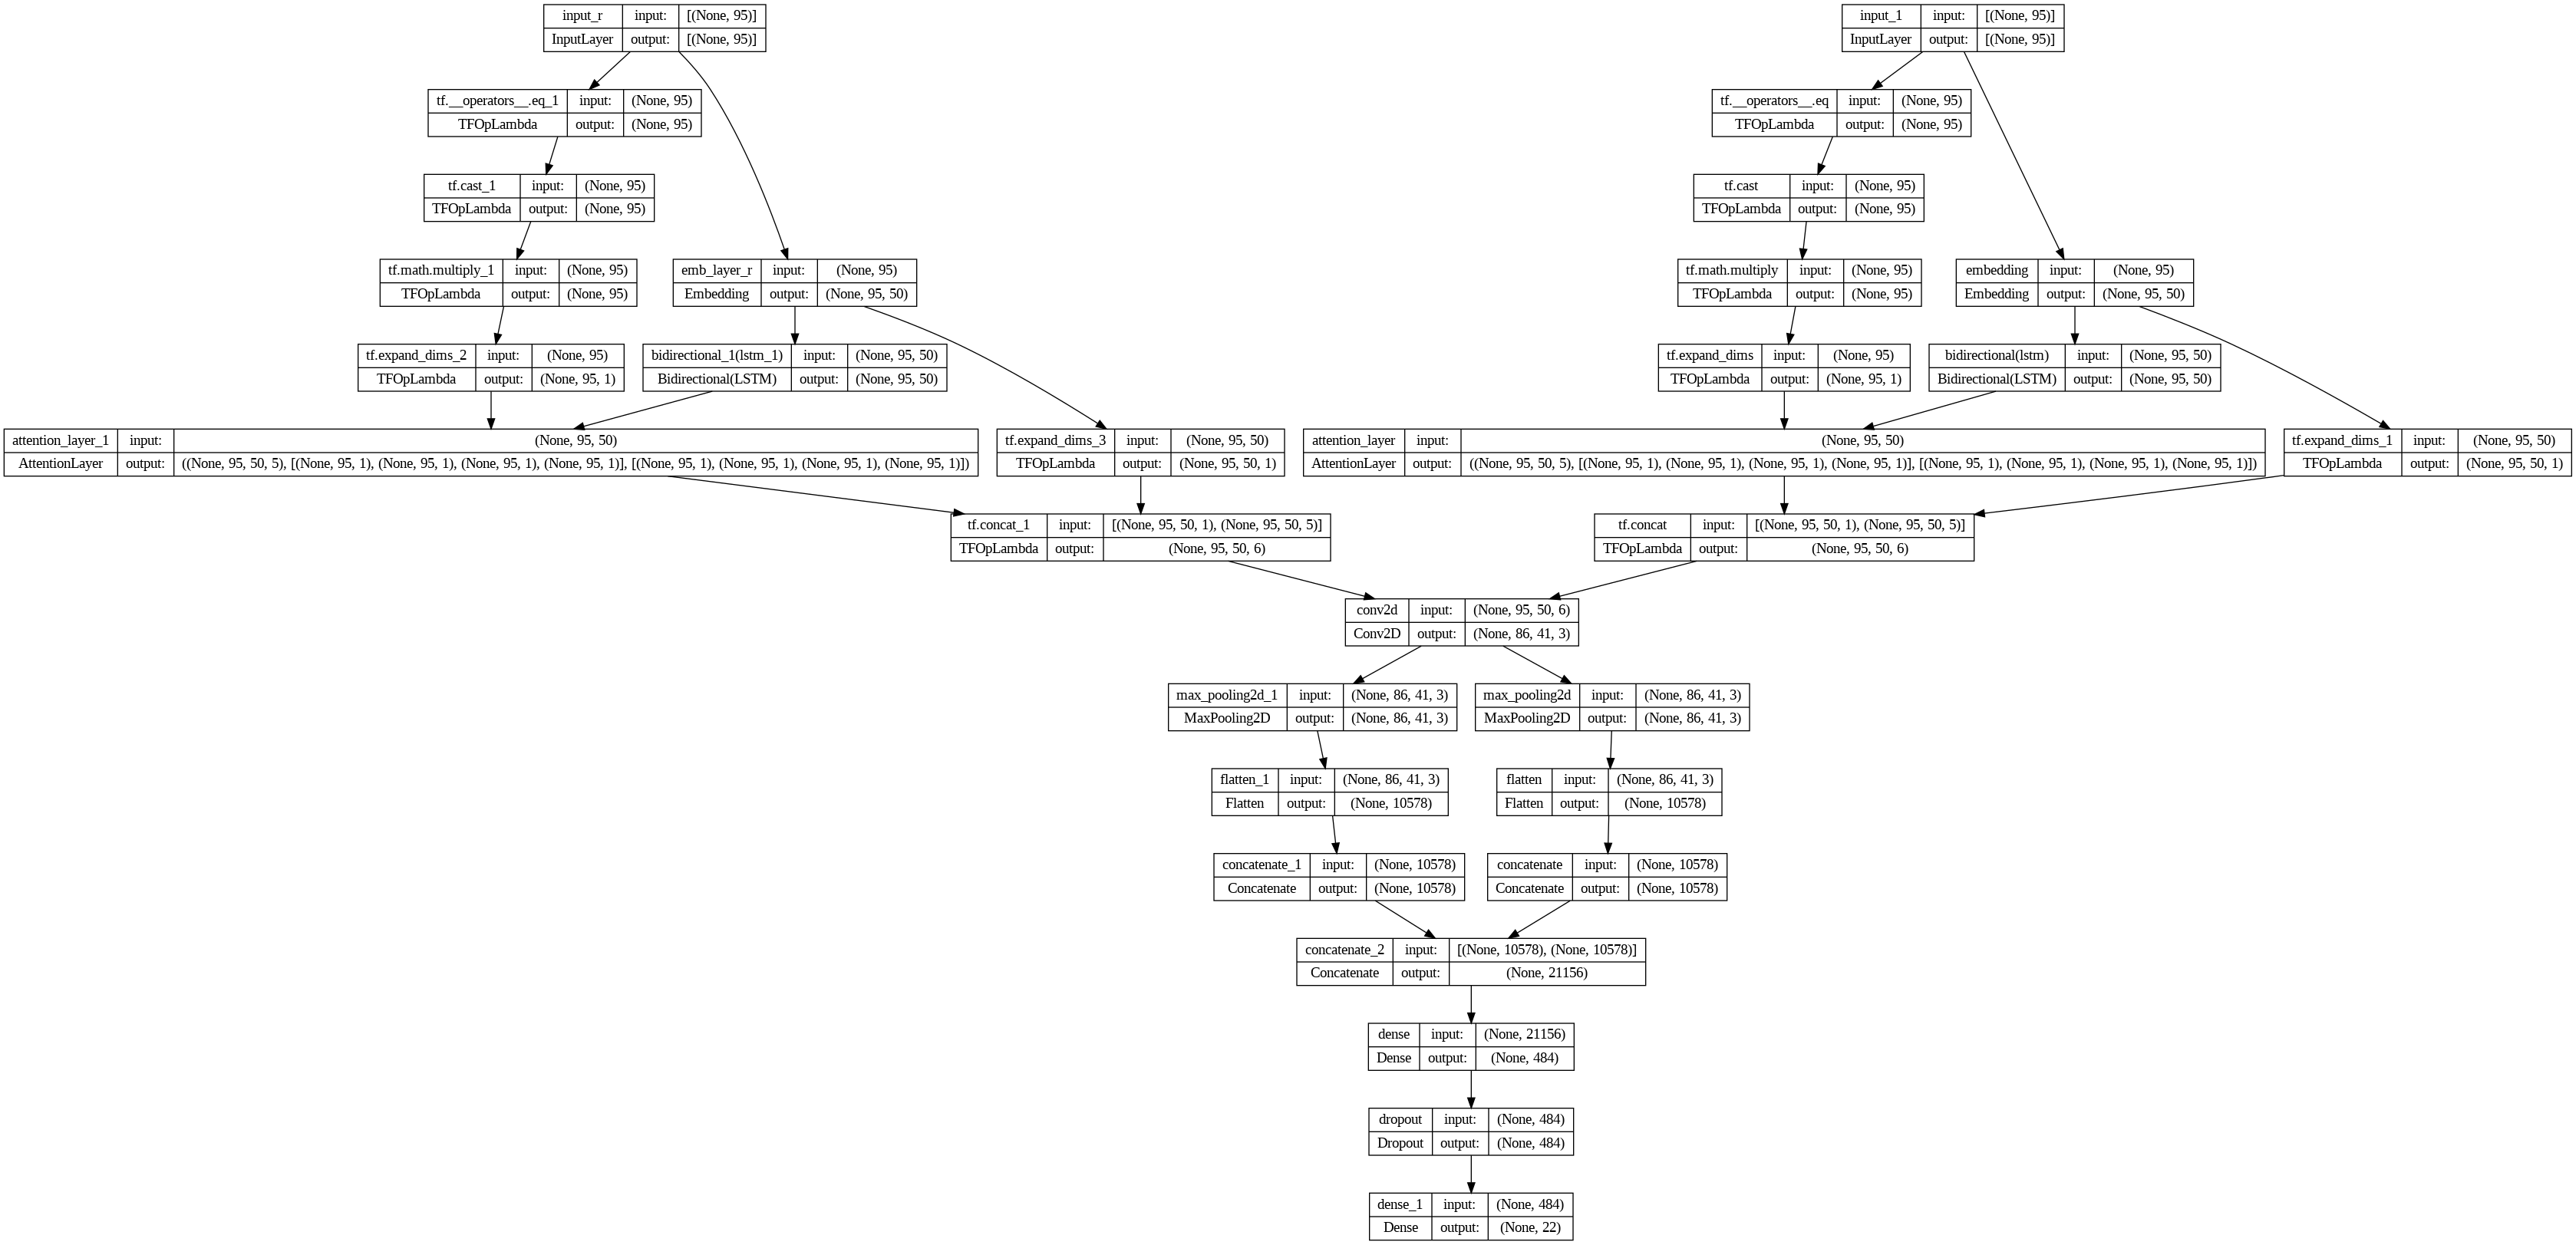

In [ ]:
inputs1 = Input(shape=(95,))
pad_k = tf.expand_dims(tf.cast((inputs1 == 0), dtype=tf.float32) * -99999, axis=2,name = "pad_k")
emb_layer = Embedding(95, 50, trainable=True)
inputs_emb = emb_layer(inputs1)
lstm_layer = LSTM(50, return_sequences=True)
bi_lstm = Bidirectional(lstm_layer, merge_mode="ave")(inputs_emb)
C_features, scalar_att, vector_att = AttentionLayer(50, 50, 4, 0.0001,0.7)(bi_lstm, pad_k)
inputs_emb2 = tf.expand_dims(inputs_emb, axis=3)
C_features = tf.concat([inputs_emb2, C_features], axis=3)
num_filters = list(range(1,2))
pools = []
for filter_sizes in num_filters:
    cnn_layers = Conv2D(3, kernel_size=(10,10), activation="relu")
    cnn_out = cnn_layers(C_features)
    max_pools = MaxPool2D(pool_size=(1 - filter_sizes + 1, 1))(cnn_out)
    max_pools = Flatten()(max_pools)
    pools.append(max_pools)
concated = concatenate(pools)


inputs_r = Input(shape=(95,), name="input_r")
pad_k_r = tf.expand_dims(tf.cast((inputs_r == 0), dtype=tf.float32) * -99999, axis=2,name="pad_r")
emb_layer_r = Embedding(95, 50, trainable=True, name="emb_layer_r")
inputs_emb_r = emb_layer_r(inputs_r)
lstm_layer_r = LSTM(50, return_sequences=True)
bi_lstm_r = Bidirectional(lstm_layer_r, merge_mode="ave")(inputs_emb_r)
C_features_r, scalar_att_r, vector_att_r = AttentionLayer(50, 50, 4, 0.0001,0.7)(bi_lstm_r, pad_k_r)
inputs_emb2_r = tf.expand_dims(inputs_emb_r, axis=3)
C_features_r = tf.concat([inputs_emb2_r, C_features_r], axis=3)

num_filters_r = list(range(1,2))
pools_r = []
for filter_sizes_r in num_filters_r:
    cnn_layers_r = Conv2D(3, kernel_size=(10,10), activation="relu")
    cnn_out_r = cnn_layers(C_features_r)
    max_pools_r = MaxPool2D(pool_size=(1 - filter_sizes_r + 1, 1))(cnn_out_r)
    max_pools_r = Flatten()(max_pools_r)
    pools_r.append(max_pools_r)
concated_r = concatenate(pools_r)


merged = concatenate([concated_r, concated])
merged_2 = Dense(484,trainable=True,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5),activation="relu")(merged)
drop1 = Dropout(0.2)(merged_2)
outputs = Dense(22,trainable=True, kernel_initializer='glorot_uniform',activation="softmax")(drop1)
model = Model(inputs= [inputs1,inputs_r], outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [ ]:
Minput[0][0].shape

(95,)

In [ ]:
from tensorflow.keras import  callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=10,
                                verbose=0,
                                mode='auto',
                                min_delta=0.0001,
                                cooldown=0,
                                min_lr=0)
histo = model.fit([Minput[0],Minput[1]],Moutput,validation_split=0.25,verbose=1,callbacks=[early_stopping, lr_reducer] , epochs=200, batch_size=256)

119/119 [==============================] - 111s 844ms/step - loss: 0.3295 - accuracy: 0.3668 - val_loss: 0.1588 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 2/200
119/119 [==============================] - 98s 827ms/step - loss: 0.1375 - accuracy: 0.5711 - val_loss: 0.1181 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 3/200
119/119 [==============================] - 100s 840ms/step - loss: 0.1081 - accuracy: 0.6522 - val_loss: 0.0984 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 4/200
119/119 [==============================] - 100s 838ms/step - loss: 0.0956 - accuracy: 0.6835 - val_loss: 0.0926 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 5/200
119/119 [==============================] - 99s 833ms/step - loss: 0.0891 - accuracy: 0.7100 - val_loss: 0.0870 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 6/200
119/119 [==============================] - 100s 841ms/step - loss: 0.0847 - accuracy: 0.7247 - val_loss: 0.0827 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 7/200
119/119 [==============================] -

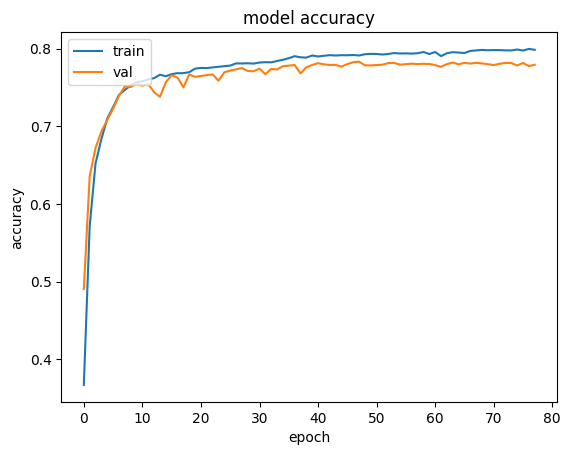

In [ ]:
from matplotlib import pyplot as plt
plt.plot(histo.history['accuracy'])
plt.plot(histo.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
histo.history['accuracy']

[0.5608072876930237,
 0.7561302185058594,
 0.7738656997680664,
 0.7807385325431824,
 0.7862135171890259,
 0.7923001050949097,
 0.797745943069458,
 0.8049973845481873,
 0.8127730488777161,
 0.8224998712539673,
 0.830129861831665,
 0.8390704393386841,
 0.8487098813056946,
 0.857679545879364,
 0.8644067645072937,
 0.8708428144454956]

In [ ]:
print("Evaluate on test data")
import pprint, pickle
inputs = open('/content/drive/MyDrive/ThesisData/modelallt_inputs.pkl', 'rb')
outputs = open('/content/drive/MyDrive/ThesisData/modelallt_outputs.pkl', 'rb')
Minput = pickle.load(inputs)
Moutput = pickle.load(outputs)
results = model.evaluate([Minput[0],Minput[1]],Moutput, batch_size=128)
y_pred_shared = model.predict([Minput[0],Minput[1]])
print("test loss, test acc:", results)

Evaluate on test data


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


542/542 [==============================] - 57s 104ms/step
test loss, test acc: [0.054038193076848984, 0.7832390069961548]
